In [1]:
import json

In [2]:
with open("05_data/StartupTimes.json") as stats:
    startup_times_overall = json.load(stats)

In [3]:
longarg_to_shortname = {
    '--exit-after-startup':                        '',
    '--disable-builtin-cli-modules':               'no_cli',
    '--disable-builtin-loadable-modules':          'no_loadable',
    '--disable-builtin-scripted-loadable-modules': 'no_scripted',
    '--disable-python':                            'no_python',
    '--disable-modules':                           'no_modules'
}

updated = {}
for (case, duration) in startup_times_overall.items():
    updated_case = []
    for part in case.split(' '):
        if part in longarg_to_shortname:
            part = longarg_to_shortname[part]
        if part:
            updated_case.append(part)
    updated_case = "+".join(updated_case)
    if updated_case == '':
        updated_case = 'all_modules'
    updated[updated_case] = duration
startup_times_overall = updated

#startup_times_overal

In [4]:
%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')

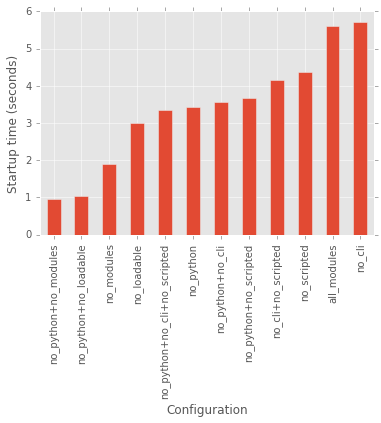

In [5]:
import pandas as pd

df = pd.DataFrame.from_dict(startup_times_overall, orient='index').sort_values(by=0)
ax = df.plot.bar(use_index=True, legend=False)
ax.set_xlabel("Configuration")
ax.set_ylabel("Startup time (seconds)")

In [6]:
df_overall = df

In [7]:
with open("05_data/StartupTimesExcludingOneModule.json") as stats:
    startup_times_excluding_one_module = json.load(stats)

In [8]:
df_times = pd.DataFrame.from_dict(startup_times_excluding_one_module, orient='index')
df_times.columns = ['time']

In [9]:
with open("05_data/Modules.json") as stats:
    module_to_module_type = json.load(stats)

In [10]:
df_types = pd.DataFrame.from_dict(module_to_module_type, orient='index')
df_types.columns = ['type']

In [11]:
df = pd.merge(df_times, df_types, left_index=True, right_index=True)

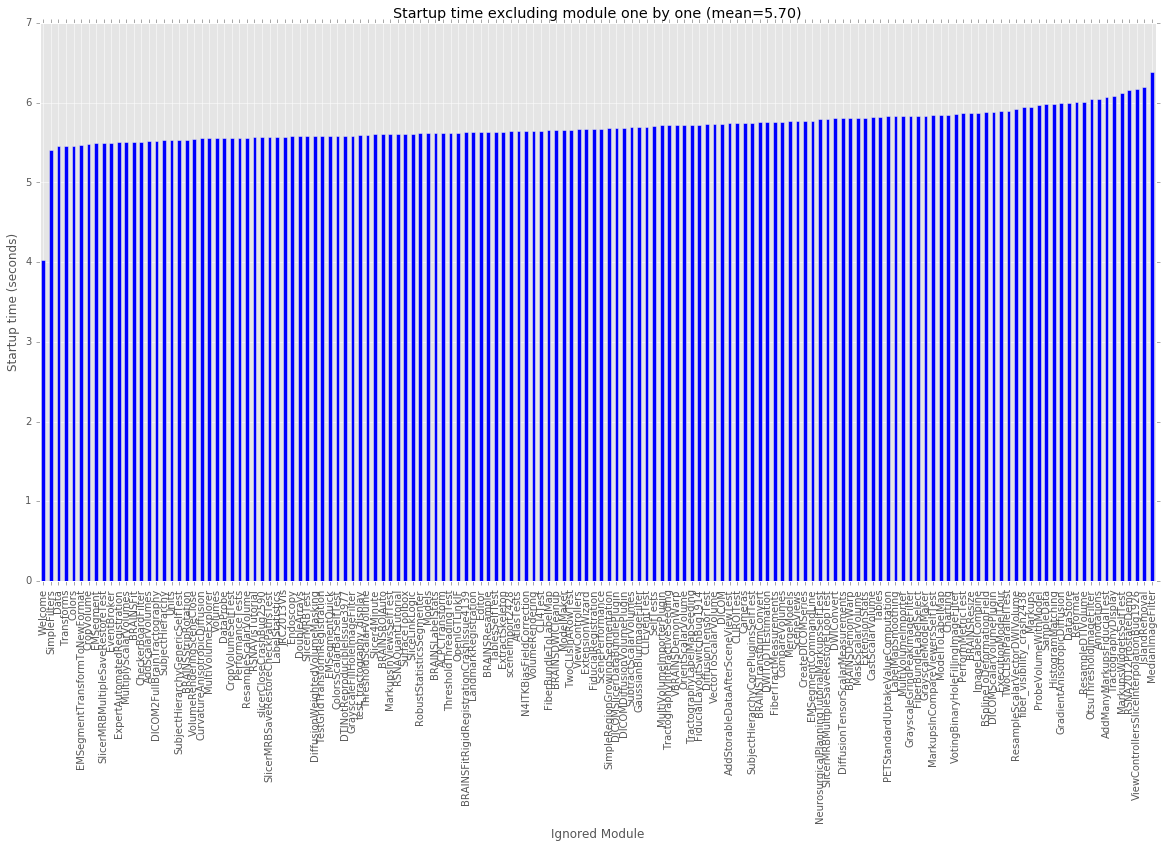

In [12]:
import matplotlib.pyplot as plt

mean_startup_time = df['time'].mean()

title = "Startup time excluding module one by one (mean={:.2f})".format(mean_startup_time)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlabel("Ignored Module")
ax.set_ylabel("Startup time (seconds)")

(df.time.sort_values()
      #.head(30)
      .plot.bar(use_index=True, title=title, color='blue', legend=False))